In [30]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
time_length = 60; #seconds
sampletot = 5000
samplenum = 4500
testsize = 1-samplenum/sampletot
epochs = 250
minibatch_size= 50
hiddenlayers = [100]
input_size = 3
output_size = 3*time_length
learning_rate = 0.01
LRdecay = 0.7
data_file_path = 'Data/Samples/data_20k_2x2x2/'
model_file_path = 'Trained_Models'
print(os.listdir(data_file_path))

['data_1.json', '.DS_Store', 'data_0.json', 'test_data', 'data_4.json', 'data_3.json', 'data_2.json']


In [32]:
#########################################
#LOAD SAMPLES
number_of_files = len(os.listdir(data_file_path))-2
number_of_samples = 1000*number_of_files

p = np.zeros((3*time_length, number_of_samples))
y_target = np.zeros((number_of_samples, 3))

for filenum in range(number_of_files):
    with open(data_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['y_target'])
        for i, p_i in enumerate(data['parameter']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for s, y_s in enumerate(data['y_target']):
            y_target[filenum*filesize+s, :] = np.array(y_s)
p = p.transpose()

print(f'Shape of y_target: {y_target.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
#y_target = y_target[~(y_target == 0).all(1)]
#p = p[~(p == 0).all(1)]
#print(y_target.shape)
#print(p.shape)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

y_target = torch.tensor(y_train).float()
p = torch.tensor(p_train).float()
y_test = torch.tensor(y_test).float()
p_test = torch.tensor(p_test).float()

Shape of y_target: (5000, 3)
shape of p: (5000, 180)


epoch:   0/250    LR:   0.010000  loss: 0.00017513
epoch:  50/250    LR:   0.003430  loss: 0.00000435
epoch: 100/250    LR:   0.001176  loss: 0.00000333
epoch: 150/250    LR:   0.000282  loss: 0.00000113
epoch: 200/250    LR:   0.000097  loss: 0.00000070
epoch: 249 final loss: 0.00000064

Training completed. Total duration: 5.241 min
(250,)


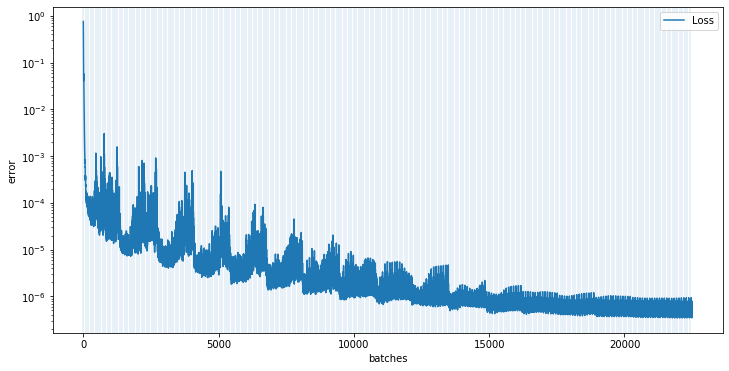

In [33]:
################################
#BUILD MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        self.L_out = nn.Linear(3*time_length, 3*time_length)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

################################################
#TRAIN THE MODEL

torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        y_i = y_target[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(y_i)

        #error claculation
        loss_batch = weight_c1* criterion(p_pred, p_i)
        losses.append(loss_batch)
        optimizer.zero_grad()
        #Back Prop
        loss_batch.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%50 == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')

print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

##################################################
#Plot loss for each batch after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
print(epoch_lines.shape)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'Loss')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

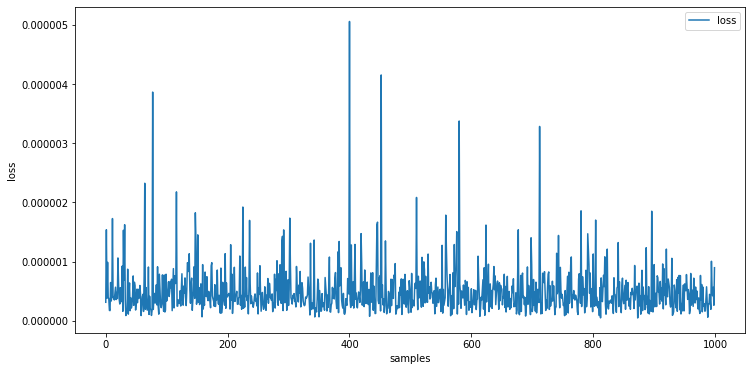

0.0004996868035966884


In [11]:
####################################################
#Test the data
losses_test= []
with torch.no_grad():
    for i in range(sampletot-samplenum):
        p_val = model(y_test[i, :])
        loss_test = criterion(p_val,p_test[i,:])
        losses_test.append(loss_test.clone().numpy())
#plot test errors
plt.figure(figsize = [12,6])
loss_test_plot = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('samples')
plt.show()
tot_error = sum(losses_test)
print(tot_error)


## PLOTS

In [13]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(sampletot-samplenum):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(180)
abs_errors_sum = torch.zeros(180)
with torch.no_grad():
    for i in range(sampletot-samplenum):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]/(sampletot-samplenum)
y_err_rel = rel_errors_sum[1::3]/(sampletot-samplenum)
z_err_rel = rel_errors_sum[2::3]/(sampletot-samplenum)

x_err = abs_errors_sum[0::3]/(sampletot-samplenum)
y_err = abs_errors_sum[1::3]/(sampletot-samplenum)
z_err = abs_errors_sum[2::3]/(sampletot-samplenum)

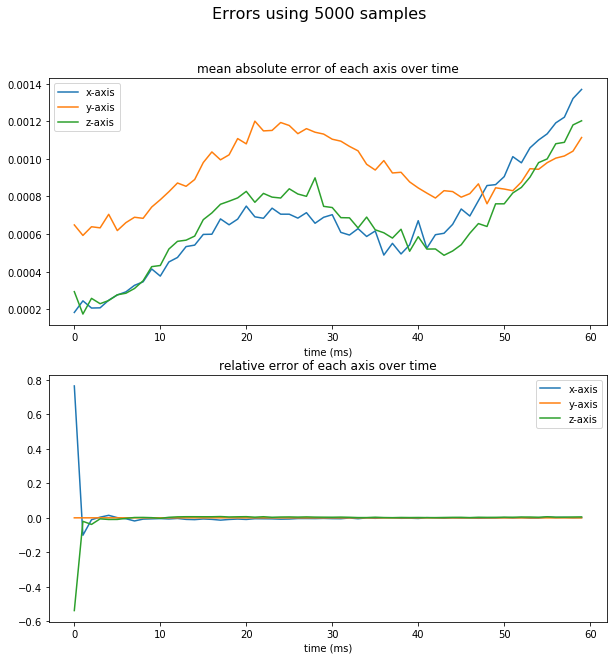

In [14]:
plt.figure(figsize = [10,10])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

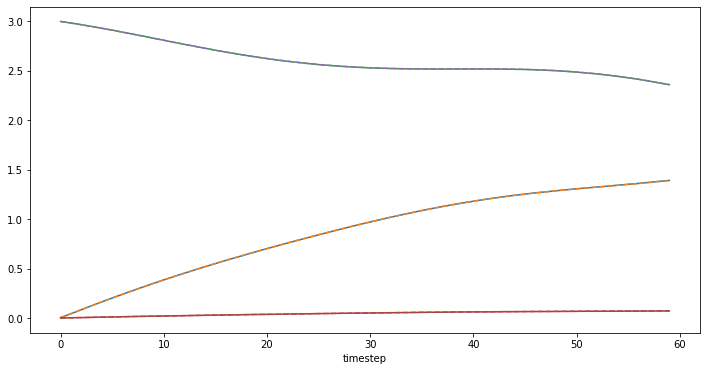

In [15]:
#x, y and z plot
randomsample = 9
with torch.no_grad():
        p_val = model(y_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val)
plt.plot(x_truth, '--')
plt.plot(y_val)
plt.plot(z_val)
plt.plot(y_truth, '--')
plt.plot(z_truth, '--')

plt.xlabel('timestep')
plt.show()

In [19]:
#####################################################
#SAVE MODEL

import time
timestr = time.strftime("%m%d")

#Save entire Model
torch.save(model, 'Trained_Models/Model_020720_supervised_20k_samples.pt')
torch.save(model, 'Trained_Models/Model_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), 'Trained_Models/state_dict/Trained_Model_statedict_20000s_250e_07lr_' + timestr + '.pt')
torch.save(model.state_dict(), 'Trained_Models/state_dict/Model_statedict_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = torch.tensor([0.5, 1.1, 0.5])
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save("Trained_Models/Serialized_Models/Serialized_model_latest.pt")
traced_script_module.save('Trained_Models/Serialized_Models/Serialized_model_2x2x2_' + timestr + '.pt')

In [21]:
#####################################################
#TEST THE MODEL

# Generate simulation
dyn = d.PyDyn('Data/point-mass_pendulum.sim', time_length)
state_init = dyn.compute(dyn.p_init)
f = dyn.f(state_init, dyn.p_init)
df = dyn.df_dp(state_init, dyn.p_init)
dy = dyn.dy_dp(state_init, dyn.p_init)

y_target_test_= torch.tensor([0.5, 1.5, 0.5])
p_ = model(y_target_test_)
y_target_ = y_target_test_.detach().numpy()
p_ = p_.detach().numpy()
p_truth_ = dyn.get_p(y_target_, dyn.p_init)

yTraj_test_ = dyn.compute(p_)
yTraj_truth_ = dyn.compute(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target: {y_target_test_}')
print(f'\nevaluated y_end: {yTraj_test_.y[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth: {yTraj_truth_.y[-3:]}')
print(f'\ndifference of y_end: {np.sum(yTraj_test_.y[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted: {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt: {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target: tensor([0.5000, 1.5000, 0.5000])

evaluated y_end: [0.49290922 1.50915791 0.49299789]

simulated traj_opt y_end with p_truth: [0.49261978 1.5094285  0.49261994]

difference of y_end: -0.004934979482752844

last 6 entries of p predicted: [0.36123222 2.5011578  0.35873204 0.36178398 2.4920015  0.35985893]

last 6 entries of p from traj_opt: [0.35960398 2.50145068 0.35959234 0.36085268 2.49238083 0.36084115]
